<a href="https://colab.research.google.com/gist/hrishipoola/d96e4d6bc0b525231703541a49262216/garch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moderna: Modeling Volatility with GARCH

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Collect Data
4. Specify & Fit Model
   <br>4a. Constant mean, normal distribution
   <br>4b. Constant mean, skewed t distribution
   <br>4c. AR mean, skewed t distribution
   <br>4d. EGARCH (asymmetric shocks)
   <br>4e. GJR-GARCH (asymmetric shocks)
5. Goodness of Fit (max likelihood, AIC, BIC)
6. Parameter Significance Testing
7. Standardized Residuals
   <br>7a. ACF Plot
   <br>7b. Ljung-Box Test
8. Rolling Window Forecast
   <br>8a. Fixed Window
   <br>8b. Expanding Window
9. Backtesting
10. Dynamic Value at Risk (VaR)
11. References 

## 1. Introduction

Today, we'll model and forecast Moderna (ticker: MRNA) equity volatility using generalized autoregressive conditional heteroskedacity[(GARCH)](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) in order to better manage investment and options risk. I was inspired by a recent [a16z interview](https://a16z.com/2020/12/18/moderna-covid-vaccine-mrna-technology/) with Moderna's CEO Stephane Bancel and a [Datacamp course](https://learn.datacamp.com/courses/garch-models-in-python). 

GARCH provides a more realistic, reliable model for volatility (risk) by incorporating the clustered, time-varying character of volatility. Periods of high or low volatility tend to persist - volatility is more likely to be high at time t if it was also high at time t-1. Rising prices tend to be accompanied with falling volatility (steady uptick) and falling prices tend to be accompanied with rising volatility (panic selling). GARCH(p,q) models variance as a weighted average of past residuals up to lag p and weighted average of variance up to lag q. For example, GARCH(1,1) states that variance of time t equals a constant, omega, plus alpha x residual squared of time t-1, plus beta x variance of time t-1:

$\sigma^2_t = \omega + \alpha * residual^2_{t-1} + \beta * \sigma^2_{t-1}$

$\alpha$ represents how volatility reacts to new information. The larger the $\alpha$, the larger the immediate impact expressed as residuals (prediction errors). For daily observations, $\alpha$ is typically between 0.5 (stable) to around 0.1 (jumpy). The larger the $\beta$, the longer the duration of the impact. $\beta$ is typically between 0.85 and 0.98. Taken together, volatility with high $\alpha$ and low $\beta$ tend to be more spiky. Key requirements are:

$\omega, \alpha, \beta$ are non-negative
<br>$\alpha + \beta < 1$ (mean-reverting)

In the long run, $\sigma = \omega / (1-\alpha - \beta)$

If our GARCH model is working well, it will account for all predictable components and its residuals will be uncorrelated (white noise).

We'll also take into account asymmetric shocks with GJR-GARCH and exponential GARCH (EGARCH), which include a conditional parameter for differing impact of bad and good news on volatility. For example, GJR-GARCH is represented as:

$\sigma^2_t = \omega + \alpha * residual^2_{t-1} + \gamma *I* residual^2_{t-1} +  \beta * \sigma^2_{t-1}$

The additional parameter $\gamma$ takes into account asymmetric shock, where I is an indicator function that equals 1 if the unconditional standard deviation is less than 0. A negative and significant $\gamma$ means bad news increases volatility more than good news of similar magnitude. A positive and significant $\gamma$ means that good news increases volatility more than bad news of the same magnitude. 

We'll specify and fit several models, check goodness of fit, select the optimal model, check parameters and standardized residuals, create a rolling window forecast, backtest, and quantify value at risk (VaR). Try it out on a company you're interested in! In a future post, we'll see how GARCH works with a portfolio. 

Volatility is only one piece of the puzzle. Next steps:
- Model expected returns separately by fitting an ARIMA model
- Run Monte Carlo simulations
- From those draws, generate a realistic high confidence band for future expected MRNA's returns


## 2. Install & Import Packages

In [153]:
# !pip install yfinance
# !pip install pandas-datareader

# Import yfinance to make Yahoo Finance API call 
# import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
from datetime import datetime
from functools import reduce 

# Import data reader to directly convert Yahoo Finance data into dataframe
from pandas_datareader import data as pdr

# !pip install arch
from arch import arch_model

# ACF plot of standardized residuals
from statsmodels.graphics.tsaplots import plot_acf

# Ljunb-Box test of standardized residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set seaborn plot style
sns.set_style("darkgrid")

# Set matplotlib plot style
style.use("fivethirtyeight")

In [154]:
import numpy as np 

## 3. Collect data

This [article](https://www.tandfonline.com/doi/abs/10.1080/13518470500039436) recommends having at least 500 observations when working with a GARCH(1,1) model in order to avoid negative bias and convergence errors. 

In [155]:
# Grab data from Yahoo Finance as dataframe
mrna = pd.read_excel('./data/MRNA.xlsx')#pdr.get_data_yahoo('MRNA', start='2018-12-03', end='2021-01-13')

# Check first 3 and last 3 rows
pd.concat([mrna.head(3), mrna.tail(3)])

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-24,153.47,158.00,138.17,157.30,157.30,16626800
1,2022-01-21,166.23,171.25,157.29,160.07,160.07,11801300
2,2022-01-20,174.99,177.47,166.21,167.52,167.52,11489600
785,2018-12-11,20.55,20.66,17.99,18.01,18.01,3435300
786,2018-12-10,18.90,19.44,18.00,18.80,18.80,4233300
787,2018-12-07,22.00,22.75,18.51,18.60,18.60,12995600


In [156]:
mrna.columns  = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [157]:
mrna["Date"]

0     2022-01-24
1     2022-01-21
2     2022-01-20
3     2022-01-19
4     2022-01-18
         ...    
783   2018-12-13
784   2018-12-12
785   2018-12-11
786   2018-12-10
787   2018-12-07
Name: Date, Length: 788, dtype: datetime64[ns]

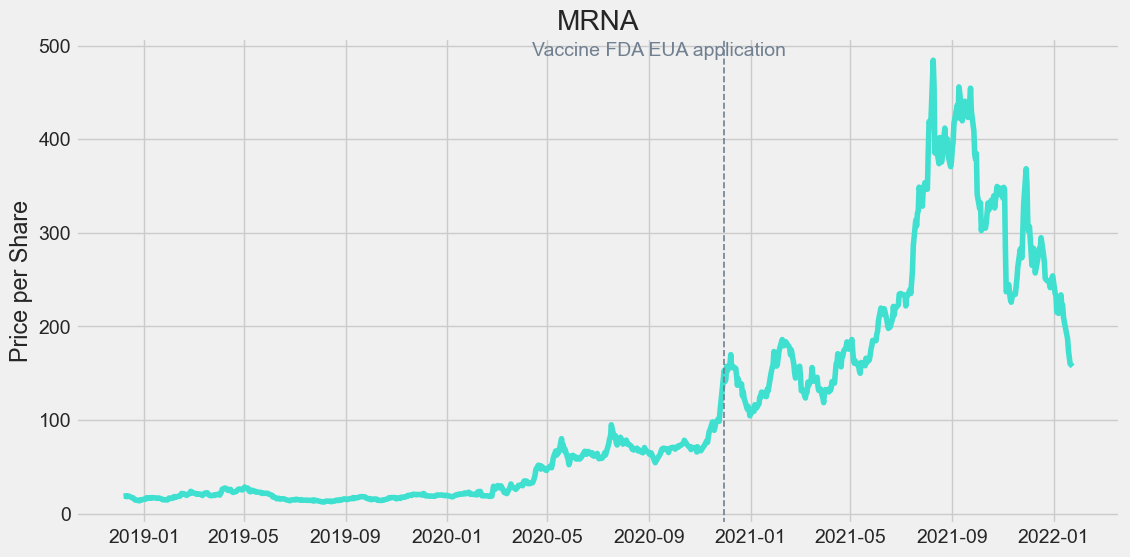

In [158]:
# Keep only Adj Close column
# mrna = mrna[['Adj Close']]

# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(mrna['Date'],mrna['Adj Close'], color='turquoise')
ax.set(title='MRNA', ylabel='Price per Share') 

ax.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2020-04-12'), max(mrna['Adj Close']+5), 'Vaccine FDA EUA application', color='slategray')
plt.show()

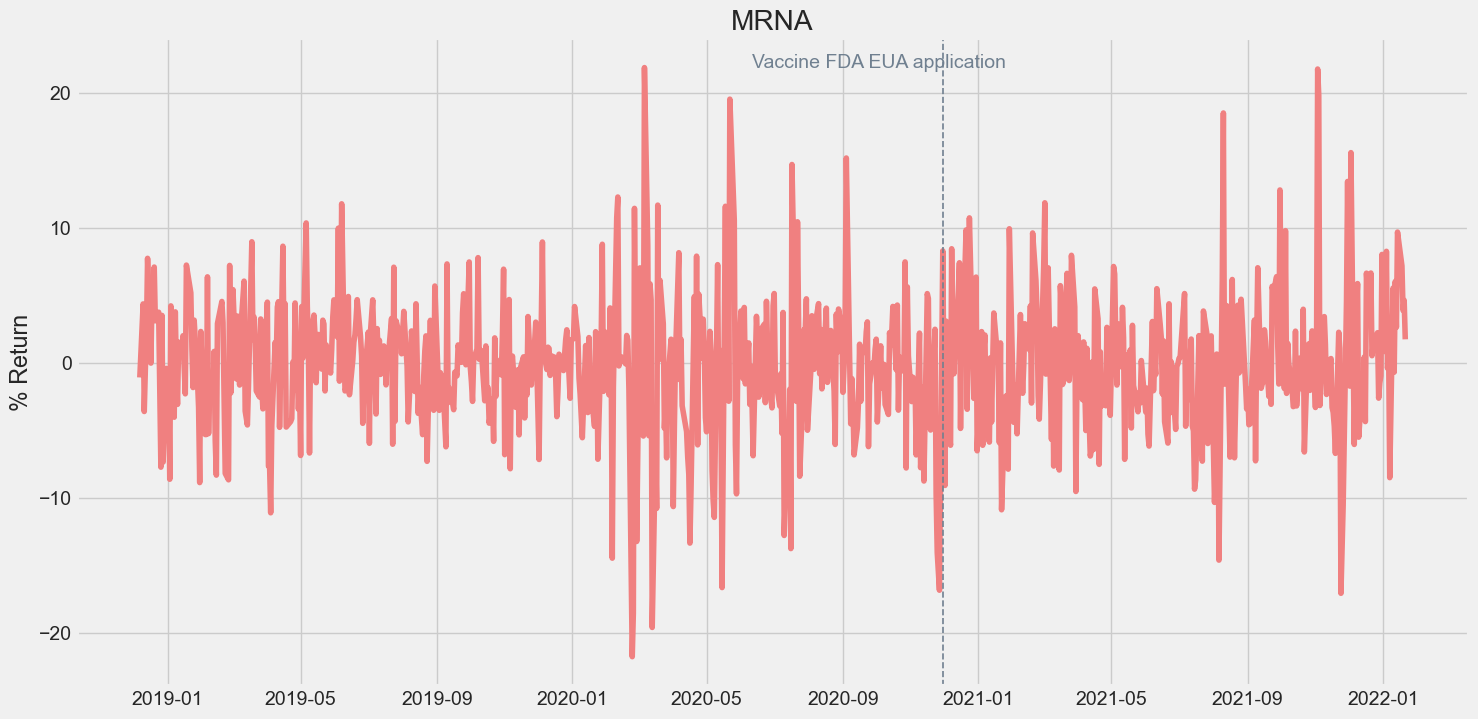

In [159]:
mrna['return'] = mrna['Close'].pct_change().dropna() * 100

# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mrna['Date'],mrna['return'], color='lightcoral')
ax.set(title='MRNA', ylabel='% Return')

ax.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2020-06-11'), max(mrna['return'].dropna()), 'Vaccine FDA EUA application', color='slategray')
plt.show()

MRNA returns show clear signs of clustering.

In [160]:
# Make sure we drop nans
mrna.dropna(inplace=True)

daily_volatility = mrna['return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_trade_days = 21
monthly_volatility = np.sqrt(monthly_trade_days) * daily_volatility
print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

yearly_trade_days = 252
yearly_volatility = np.sqrt(yearly_trade_days) * daily_volatility
print('Yearly volatility: ', '{:.2f}%'.format(yearly_volatility))

Daily volatility:  5.12%
Monthly volatility:  23.44%
Yearly volatility:  81.20%


3 steps to develop GARCH model
- Specify model (assumptions)
- Fit
- Forecast

Model assumptions
- distribution of residuals: normal, t, skewt
- mean model: constant, zero, AR
- volatility model: GARCH, ARCH, EGARCH

Fitting process finds paramaters for which the GARCH model is most likely to generate the observed time series data. 


## 4. Specify & Fit Model

## 4a. Constant mean, normal distribution

In [161]:
basic_gm = arch_model(mrna['return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal') 
gm_result = basic_gm.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3836.825479110515
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3499.9903705565494
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2436.047051192051
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2707.6711979419415
Iteration:      5,   Func. Count:     33,   Neg. LLF: 2357.245332703413
Iteration:      6,   Func. Count:     39,   Neg. LLF: 2357.1915990987877
Iteration:      7,   Func. Count:     44,   Neg. LLF: 2357.191549545898
Iteration:      8,   Func. Count:     49,   Neg. LLF: 2357.191547537497
Iteration:      9,   Func. Count:     53,   Neg. LLF: 2357.1915475374917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2357.191547537497
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9


In [162]:
gm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2357.19
Distribution:                  Normal   AIC:                           4722.38
Method:            Maximum Likelihood   BIC:                           4741.06
                                        No. Observations:                  787
Date:                Tue, Apr 01 2025   Df Residuals:                      786
Time:                        20:25:01   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0274      0.170     -0.161      0.872 [ -0.360,  0.306]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.2043      1.972      1.625      0.104   [ -0.660,  7.069]
alpha[1]       0.1623  6.317e-02      2.568  1.022e-02 [3.843e-02,  0.286]
beta[1]        0.7160      0.128      5.601  2.129e-08   [  0.465,  0.967]
==========================================================================

Covariance estimator: robust
"""

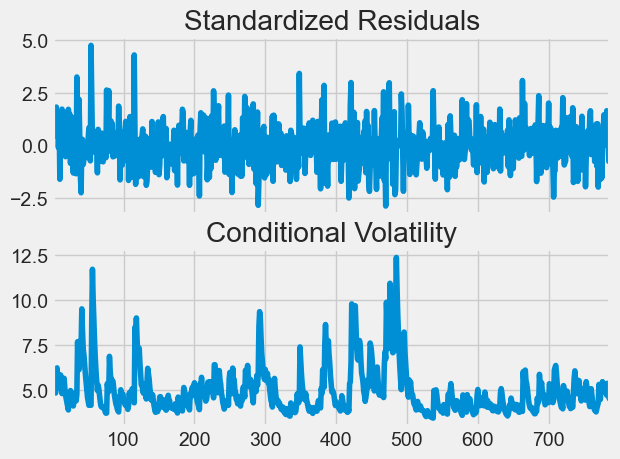

In [163]:
gm_result.plot()
plt.show()

In [164]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

           h.1        h.2        h.3        h.4        h.5
787  18.384852  19.351671  20.200828  20.946643  21.601693


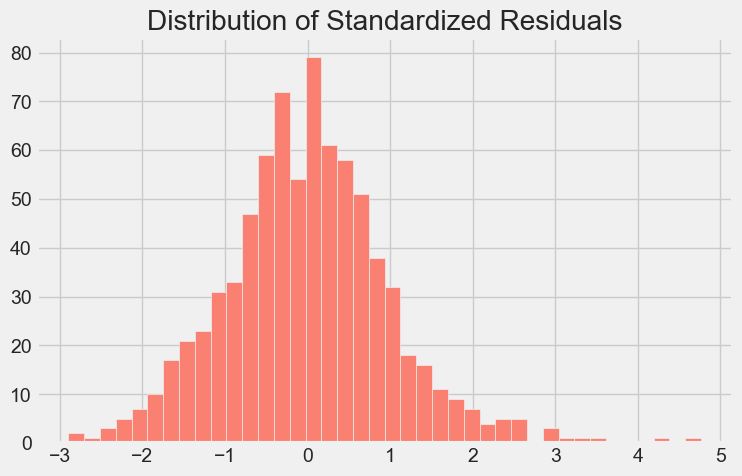

In [165]:
# Calculate standardized residual
gm_std_resid = gm_result.resid / gm_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(gm_std_resid, color='salmon', bins=40)
ax.set(title='Distribution of Standardized Residuals')
plt.show()

The distribution of standardized residuals is closer to a t-distribution with fatter tails than normal and with positive skew. Let's try fitting with a skewt distribution below.




## 4b. Constant mean, skewed t distribution

In [166]:
skewt_gm = arch_model(mrna['return'], p=1, q=1, mean='constant', vol='GARCH', dist='skewt') 
skewt_result = skewt_gm.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 3742.3781636105055
Iteration:      2,   Func. Count:     16,   Neg. LLF: 70233.73306443729
Iteration:      3,   Func. Count:     25,   Neg. LLF: 8095.908838242158
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2416.411179913238
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2376.1261230513383
Iteration:      6,   Func. Count:     51,   Neg. LLF: 2369.8412275131086
Iteration:      7,   Func. Count:     59,   Neg. LLF: 2344.1818826403423
Iteration:      8,   Func. Count:     67,   Neg. LLF: 2344.0356054075955
Iteration:      9,   Func. Count:     74,   Neg. LLF: 2344.033053962701
Iteration:     10,   Func. Count:     81,   Neg. LLF: 2344.0306336191497
Iteration:     11,   Func. Count:     88,   Neg. LLF: 2344.0301304824125
Iteration:     12,   Func. Count:     95,   Neg. LLF: 2344.0300401767677
Iteration:     13,   Func. Count:    102,   Neg. LLF: 2344.0300383022995
Iteration:     14,   Func. Count:    108,   Neg. LLF: 2

In [167]:
skewt_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                            return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -2344.03
Distribution:      Standardized Skew Student's t   AIC:                           4700.06
Method:                       Maximum Likelihood   BIC:                           4728.07
                                                   No. Observations:                  787
Date:                           Tue, Apr 01 2025   Df Residuals:                      786
Time:                                   20:25:04   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0728      0.168     -0.435      0.664 [ -0.401,  0.255]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.2175      2.079      1.548      0.122   [ -0.857,  7.292]
alpha[1]       0.1680  7.049e-02      2.384  1.714e-02 [2.987e-02,  0.306]
beta[1]        0.7113      0.136      5.242  1.587e-07   [  0.445,  0.977]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            7.8728      2.070      3.803  1.431e-04    [  3.815, 11.930]
lambda         0.0651  4.814e-02      1.353      0.176 [-2.924e-02,  0.159]
===========================================================================

Covariance estimator: robust
"""

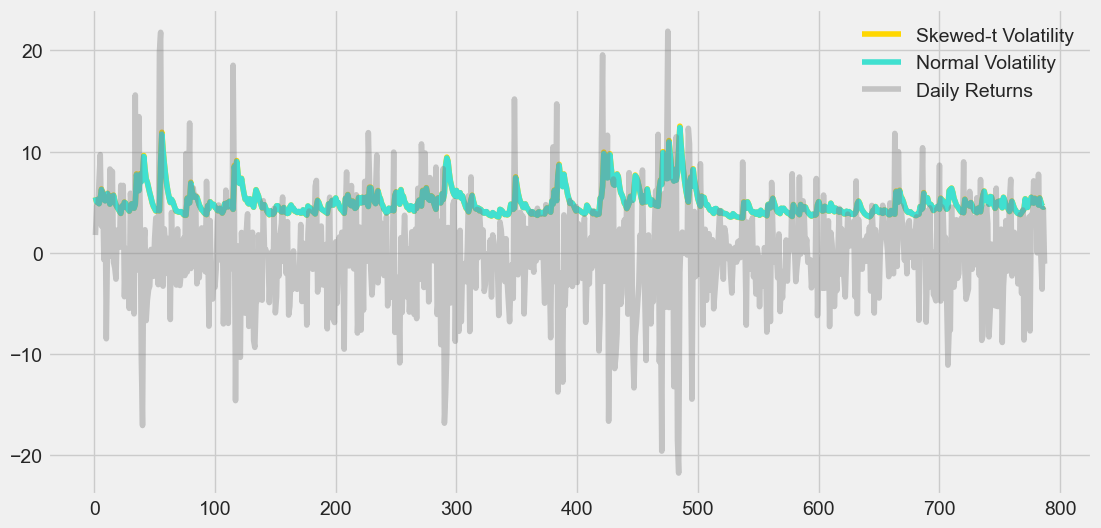

In [168]:
# Get model estimated volatility
normal_volatility = gm_result.conditional_volatility
skewt_volatility = skewt_result.conditional_volatility

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(skewt_volatility, color = 'gold', label = 'Skewed-t Volatility')
plt.plot(normal_volatility, color = 'turquoise', label = 'Normal Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)
plt.show()

The gold skew-t plot begins to diverge more from the normal plot in March 2020. 

## 4c. Autoregressive (AR) Mean, skewed t distribution

In [169]:
armean_gm = arch_model(mrna['return'], p=1, q=1, mean='AR', lags=1, vol='GARCH', dist='skewt') 
armean_result = armean_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 105897.74674808774
Iteration:      2,   Func. Count:     20,   Neg. LLF: 129471.9126259883
Iteration:      3,   Func. Count:     30,   Neg. LLF: 30708.46907951877
Iteration:      4,   Func. Count:     39,   Neg. LLF: 10788.424450069524
Iteration:      5,   Func. Count:     49,   Neg. LLF: 2398.6342874508637
Iteration:      6,   Func. Count:     59,   Neg. LLF: 2403.896755708428
Iteration:      7,   Func. Count:     69,   Neg. LLF: 2341.3169881967206
Iteration:      8,   Func. Count:     77,   Neg. LLF: 2340.9803744846054
Iteration:      9,   Func. Count:     85,   Neg. LLF: 2340.962188904711
Iteration:     10,   Func. Count:     93,   Neg. LLF: 2340.947914724526
Iteration:     11,   Func. Count:    101,   Neg. LLF: 2340.9420456978723
Iteration:     12,   Func. Count:    109,   Neg. LLF: 2340.9401029412566
Iteration:     13,   Func. Count:    117,   Neg. LLF: 2340.939808486288
Iteration:     14,   Func. Count:    125,   Neg. LLF: 234

In [170]:
armean_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                
=========================================================================================
Dep. Variable:                            return   R-squared:                       0.003
Mean Model:                                   AR   Adj. R-squared:                  0.001
Vol Model:                                 GARCH   Log-Likelihood:               -2340.94
Distribution:      Standardized Skew Student's t   AIC:                           4695.88
Method:                       Maximum Likelihood   BIC:                           4728.55
                                                   No. Observations:                  786
Date:                           Tue, Apr 01 2025   Df Residuals:                      784
Time:                                   20:25:07   Df Model:                            2
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const         -0.0736      0.166     -0.443      0.658    [ -0.399,  0.252]
return[1]      0.0312  3.824e-02      0.816      0.415 [-4.375e-02,  0.106]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.1529      2.003      1.574      0.115   [ -0.773,  7.079]
alpha[1]       0.1653  6.815e-02      2.425  1.531e-02 [3.169e-02,  0.299]
beta[1]        0.7159      0.131      5.467  4.567e-08   [  0.459,  0.973]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            7.8570      2.063      3.808  1.399e-04    [  3.813, 11.901]
lambda         0.0643  4.754e-02      1.352      0.176 [-2.892e-02,  0.157]
===========================================================================

Covariance estimator: robust
"""

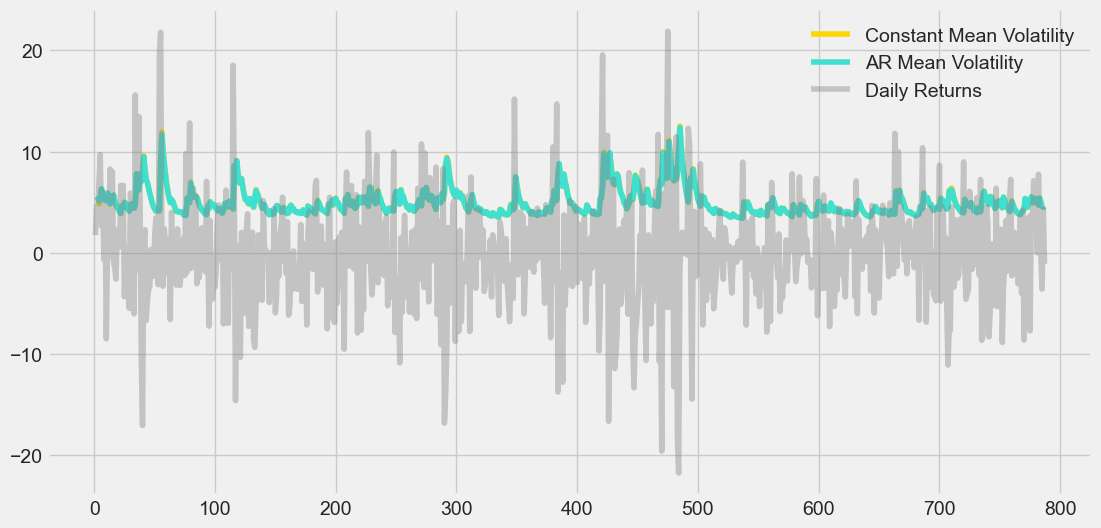

In [171]:
armean_volatility = armean_result.conditional_volatility.dropna() # uses lag, first row will be NaN
skewt_volatility = skewt_volatility.iloc[1:] # drop first row

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(skewt_volatility, color = 'gold', label = 'Constant Mean Volatility')
plt.plot(armean_volatility, color = 'turquoise', label = 'AR Mean Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)
plt.show()

In [172]:
# Correlation 
np.corrcoef(skewt_volatility, armean_volatility)[0,1]

np.float64(0.9995063931655402)

Correlation is close to 1 and both models look similar, we can assume the simplest specification for mean - constant mean.  

## 4d. EGARCH (asymmetric shock) 

So far we've assumed that positive and negative movements in return have the same (symmetric) impact on volatility. In reality, they often impact volatility asymmetrically with returns increasing gradually and falling sharply (as companies become more leveraged due to higher debt-to-equity ratio). GJR-GARCH and exponential GARCH (EGARCH) are volatility models for asymmetric shocks that include a conditional parameter (o = 1) for differing impact. 

In [173]:
egarch_gm = arch_model(mrna['return'], p=1, q=1, o=1, mean='constant', vol='EGARCH', dist='skewt') 
egarch_result = egarch_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 67231.40672772561
Iteration:      2,   Func. Count:     20,   Neg. LLF: 35833.09133373943
Iteration:      3,   Func. Count:     32,   Neg. LLF: 53163.520356122
Iteration:      4,   Func. Count:     43,   Neg. LLF: 41163.21898375465
Iteration:      5,   Func. Count:     53,   Neg. LLF: 2530.4944204346334
Iteration:      6,   Func. Count:     63,   Neg. LLF: 2354.6205006120335
Iteration:      7,   Func. Count:     72,   Neg. LLF: 2344.5370201375335
Iteration:      8,   Func. Count:     81,   Neg. LLF: 2344.2554232048433
Iteration:      9,   Func. Count:     89,   Neg. LLF: 2344.2368417890993
Iteration:     10,   Func. Count:     97,   Neg. LLF: 2344.233406368384
Iteration:     11,   Func. Count:    105,   Neg. LLF: 2344.2322044545494
Iteration:     12,   Func. Count:    113,   Neg. LLF: 2344.2321293478954
Iteration:     13,   Func. Count:    121,   Neg. LLF: 2344.2321263974804
Iteration:     14,   Func. Count:    128,   Neg. LLF: 2344

In [174]:
egarch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - EGARCH Model Results                          
=========================================================================================
Dep. Variable:                            return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -2344.23
Distribution:      Standardized Skew Student's t   AIC:                           4702.46
Method:                       Maximum Likelihood   BIC:                           4735.14
                                                   No. Observations:                  787
Date:                           Tue, Apr 01 2025   Df Residuals:                      786
Time:                                   20:25:10   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0547      0.162     -0.338      0.735 [ -0.371,  0.262]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.4362      0.538      0.810      0.418    [ -0.619,  1.491]
alpha[1]       0.3160      0.182      1.739  8.211e-02 [-4.025e-02,  0.672]
gamma[1]       0.0600  7.243e-02      0.829      0.407 [-8.195e-02,  0.202]
beta[1]        0.8656      0.169      5.132  2.864e-07    [  0.535,  1.196]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            7.6041      1.936      3.927  8.606e-05    [  3.809, 11.399]
lambda         0.0601  4.874e-02      1.234      0.217 [-3.539e-02,  0.156]
===========================================================================

Covariance estimator: robust
"""

## 4e. GJR-GARCH

In [175]:
gjrgarch_gm = arch_model(mrna['return'], p=1, q=1, o=1, mean='constant', vol='GARCH', dist='skewt') 
gjrgarch_result = gjrgarch_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 60630.95386073641
Iteration:      2,   Func. Count:     19,   Neg. LLF: 14485.380367448199
Iteration:      3,   Func. Count:     29,   Neg. LLF: 2606.932576764333
Iteration:      4,   Func. Count:     39,   Neg. LLF: 2425.0405417691386
Iteration:      5,   Func. Count:     49,   Neg. LLF: 2683.580746841881
Iteration:      6,   Func. Count:     59,   Neg. LLF: 2398.4802379338853
Iteration:      7,   Func. Count:     69,   Neg. LLF: 2343.074551435908
Iteration:      8,   Func. Count:     77,   Neg. LLF: 2343.050982622788
Iteration:      9,   Func. Count:     85,   Neg. LLF: 2343.04234466454
Iteration:     10,   Func. Count:     93,   Neg. LLF: 2343.035538116282
Iteration:     11,   Func. Count:    101,   Neg. LLF: 2343.034067581214
Iteration:     12,   Func. Count:    109,   Neg. LLF: 2343.033601656158
Iteration:     13,   Func. Count:    117,   Neg. LLF: 2343.0335132728605
Iteration:     14,   Func. Count:    125,   Neg. LLF: 2343.03

In [176]:
gjrgarch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                         
=========================================================================================
Dep. Variable:                            return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -2343.03
Distribution:      Standardized Skew Student's t   AIC:                           4700.07
Method:                       Maximum Likelihood   BIC:                           4732.74
                                                   No. Observations:                  787
Date:                           Tue, Apr 01 2025   Df Residuals:                      786
Time:                                   20:25:12   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0517      0.165     -0.313      0.754 [ -0.376,  0.272]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          4.1049      2.450      1.675  9.390e-02   [ -0.698,  8.908]
alpha[1]       0.2491      0.127      1.963  4.959e-02 [4.424e-04,  0.498]
gamma[1]      -0.1169      0.121     -0.968      0.333   [ -0.354,  0.120]
beta[1]        0.6565      0.149      4.396  1.104e-05   [  0.364,  0.949]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            8.2151      2.271      3.617  2.976e-04    [  3.764, 12.666]
lambda         0.0676  4.908e-02      1.377      0.169 [-2.863e-02,  0.164]
===========================================================================

Covariance estimator: robust
"""

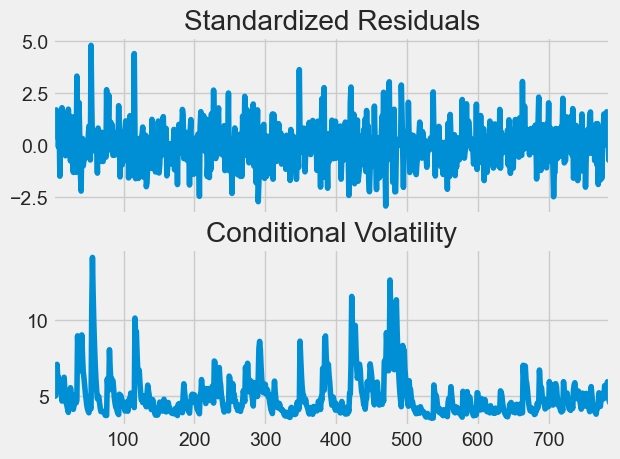

In [177]:
gjrgarch_result.plot()

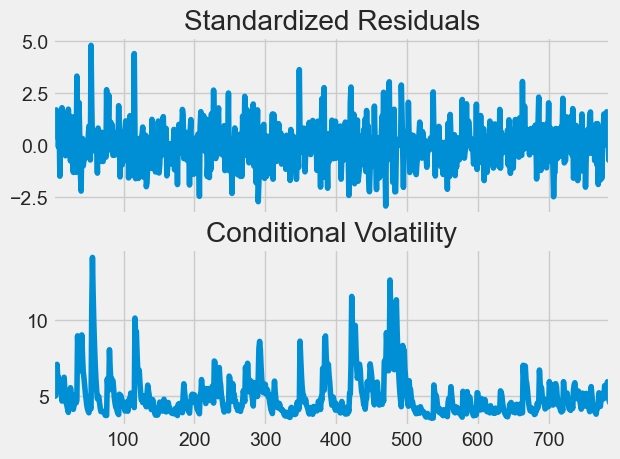

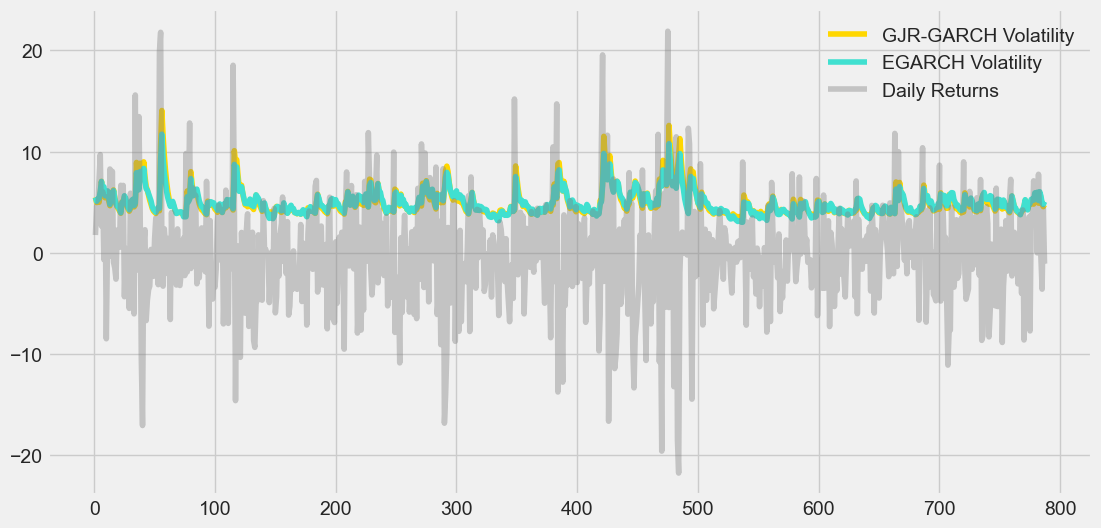

In [178]:
# Get model estimated volatility
gjrgarch_volatility = gjrgarch_result.conditional_volatility
egarch_volatility = egarch_result.conditional_volatility

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(gjrgarch_volatility, color = 'gold', label = 'GJR-GARCH Volatility')
plt.plot(egarch_volatility, color = 'turquoise', label = 'EGARCH Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)
plt.show()

## 5. Goodness of Fit

1. Log Likelhood (maximize)
2. Information Criteria (AIC, BIC) (minimize)

Based on log likelihood, AIC, BIC below, GJR-GARCH is our best fitting model

In [179]:
# Function to create dataframe of log likelihood, AIC, BIC for each model
def goodness_of_fit():
  global df
  model_names = ['normal', 'skewt', 'GJR-GARCH', 'EGARCH']
  models = [gm_result, skewt_result, gjrgarch_result, egarch_result]
  likelihood = [model.loglikelihood for model in models]
  aic = [model.aic for model in models]
  bic = [model.bic for model in models]
  dict = {'model':model_names, 'log likelihood':likelihood, 'aic':aic,'bic':bic}
  df = pd.DataFrame(dict).set_index('model')
  return df

goodness_of_fit()

,log likelihood,aic,bic
model,,,
normal,-2357.191548,4722.383095,4741.056008
skewt,-2344.030038,4700.060077,4728.069446
GJR-GARCH,-2343.033501,4700.067002,4732.744599
EGARCH,-2344.232126,4702.464253,4735.141851


In [180]:
# Highlight max log likelihood
df.style.highlight_max(subset='log likelihood', color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-2357.191548,4722.383095,4741.056008
skewt,-2344.030038,4700.060077,4728.069446
GJR-GARCH,-2343.033501,4700.067002,4732.744599
EGARCH,-2344.232126,4702.464253,4735.141851


GJR-GARCH performs the best in terms of log likelihood.

In [181]:
# Highlight min AIC, BIC
df.style.highlight_min(subset=['aic', 'bic'], color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-2357.191548,4722.383095,4741.056008
skewt,-2344.030038,4700.060077,4728.069446
GJR-GARCH,-2343.033501,4700.067002,4732.744599
EGARCH,-2344.232126,4702.464253,4735.141851


GJR-GARCH has the lowest AIC, while GJR-GARCH and skewed t have the lowest BIC. Based on this, let's select GJR-GARCH as our model.  

## 6. Parameter Significance Testing

Significance testing of parameters is one piece of understanding our model, but, in terms of variable selection, it should be taken with a grain of salt ([article](https://robjhyndman.com/hyndsight/tests2/)) - it's possible to have an insignificant coefficient for a variable that's useful for forecasting as well as having a significant variable that's better omitted for forecasting. We'll also look at residuals as well as AIC and BIC below. 




In [182]:
# Get parameter stats from model summary
parameters = pd.DataFrame({'parameter': gjrgarch_result.params,
                           'p-value': gjrgarch_result.pvalues})

parameters

,parameter,p-value
mu,-0.051709,0.754314
omega,4.104900,0.093902
alpha[1],0.249132,0.049594
gamma[1],-0.116897,0.333041
beta[1],0.656549,0.000011
eta,8.215061,0.000298
lambda,0.067561,0.168630


The high $\alpha$ indicates a large immediate impact on residuals, while the relatively high $\beta$ indicates a persisting impact. The negative $\gamma$ implies that bad news increases volatility more than good news of similar magnitude. From the significance test, omega and alpha aren't significant (p-values above 0.05). However, we should be [careful about removing them](https://stats.stackexchange.com/questions/202493/should-i-keep-a-non-significant-intercept-in-a-garch-model) based on this. 




## 7. Standardized Residuals

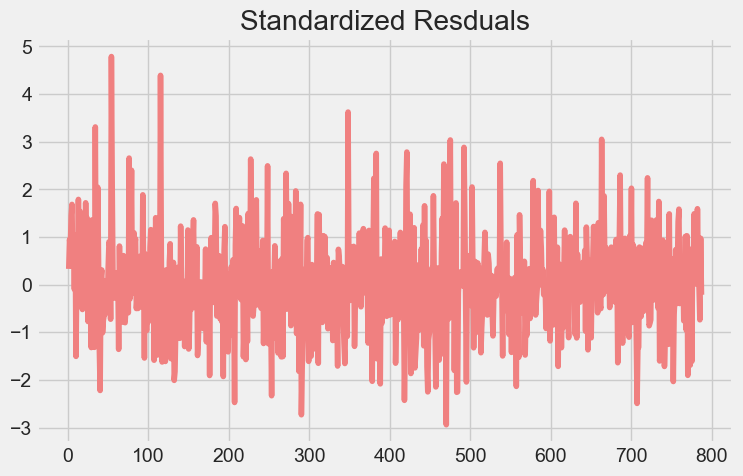

In [183]:
# Calculate standardized residual
gjrgarch_std_resid = gjrgarch_result.resid / gjrgarch_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(gjrgarch_std_resid, color='lightcoral')
ax.set(title='Standardized Resduals') 
plt.show()

Autocorrelation tests randomness in standardized residuals for each lag and any significant autocorrelation in standardized residuals means the model may not be sound.

## 7a. ACF Plot

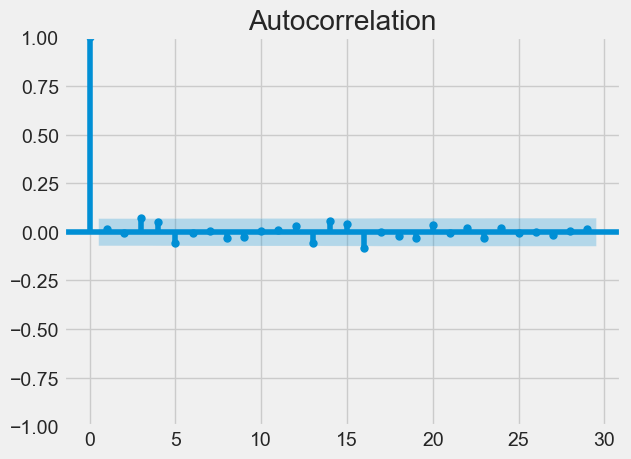

In [184]:
plot_acf(gjrgarch_std_resid, alpha=0.05)

The ACF plots illustrate that there aren't any significant autocorrelations between residuals so the residuals represent white noise.

## 7b. Ljung-Box Test

Ljung-Box tests for overall randomness of standardized residuals. The null hypothesis is that the data is independently distributed. P-values <5% means the residuals aren't independently distributed and the model isn't sound. 


In [185]:
# Ljung-Box test
lb_test = acorr_ljungbox(gjrgarch_std_resid, lags=10)
print(lb_test)

# P-values dataframe, transpose to get lags as columns
p_values = pd.DataFrame({'P-values': lb_test['lb_pvalue']}).T

# Create column names for each lag
col_num = p_values.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
p_values.columns = col_names
p_values

      lb_stat  lb_pvalue
1    0.152007   0.696625
2    0.195358   0.906940
3    4.221509   0.238517
4    6.239584   0.181956
5    9.067309   0.106409
6    9.113200   0.167311
7    9.119834   0.244167
8    9.882066   0.273401
9   10.413631   0.318048
10  10.426618   0.403895


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
P-values,0.696625,0.90694,0.238517,0.181956,0.106409,0.167311,0.244167,0.273401,0.318048,0.403895


All the p-values are above 5% meaning the null hypothesis can't be rejected and the standardized residuals are independently distributed. 

## 8. Rolling Window Forecast

To avoid lookback bias and be more responsive to recent events, let's create rolling window forecasts with both fixed and expanding windows. When setting the window size, too large a window may include obsolete data while too small a window might exclude relevant information (and increase variance). As we have a bit over 500 trading days in our data set and we've seen dramatic recent macro shifts and events related to vaccine development, we'll set the start location going back half a year, the window size to 60 trading days, and the forecast period to 30 days.   

## 8a. Fixed Window

           h.1
721  19.170396
722  30.962802
723  28.357546
724  25.881414
725  15.996460
..         ...
783  15.996460
784  16.875869
785  26.021087
786  15.996460
787  17.920810

[67 rows x 1 columns] 0 721 721
           h.1
722  31.748785
723  28.942050
724  26.282388
725  16.016350
726  16.016350
..         ...
783  16.016350
784  16.795808
785  26.432160
786  16.016350
787  17.854335

[66 rows x 1 columns] 1 721 722
           h.1
723  24.008444
724  22.173517
725  15.435728
726  15.435728
727  17.338045
..         ...
783  15.435728
784  15.825691
785  22.276578
786  15.435728
787  16.488480

[65 rows x 1 columns] 2 721 723
           h.1
724  22.531016
725  15.721947
726  15.721947
727  17.589215
728  15.739689
..         ...
783  15.721947
784  16.076316
785  22.636881
786  15.721947
787  16.733158

[64 rows x 1 columns] 3 721 724
           h.1
725  15.384623
726  15.384623
727  17.499083
728  15.405583
729  15.384623
..         ...
783  15.384623
784  15.788311
785  23.19758

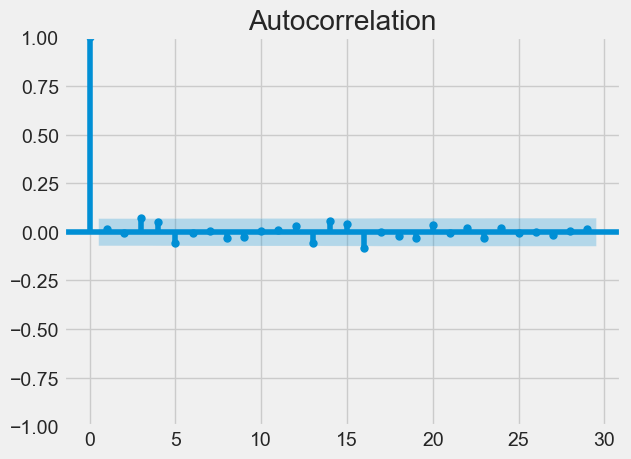

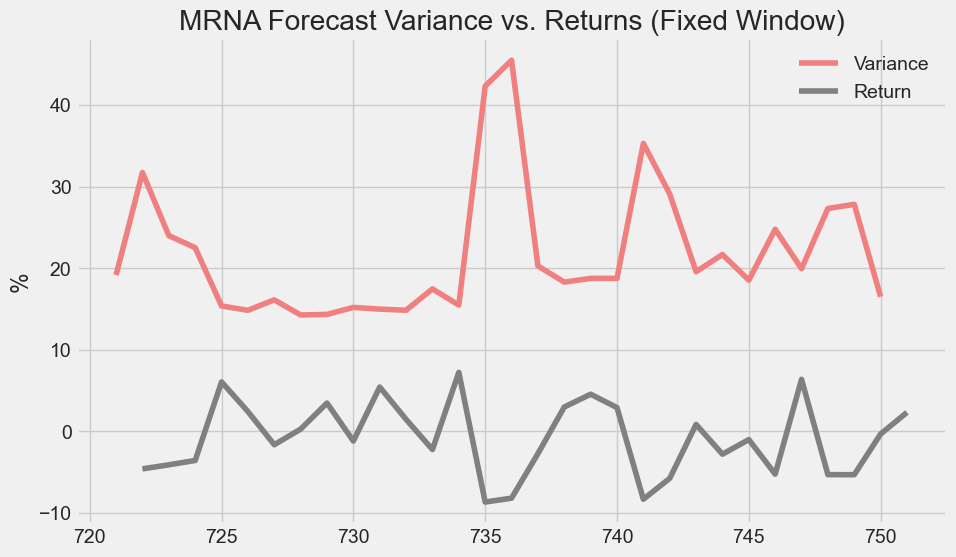

In [186]:
# Start location set to going back with a half year of trading days
start_loc = len(mrna) - round(0.5 * yearly_trade_days)

# Window of 60 days
end_loc = start_loc + 60

forecasts={}

for i in range(30):

    # Fit with fixed rolling window
    gjrgarch_fixed_rolling_result = gjrgarch_gm.fit(first_obs = i + start_loc, 
                                              last_obs = i + end_loc, 
                                              update_freq = 5,
                                              disp='off')
    
    # 1-period variance forecast and save the result
    temp_result = gjrgarch_fixed_rolling_result.forecast(horizon = 1).variance
    print(temp_result,i,end_loc,i+end_loc)
    fcast = temp_result.loc[i + end_loc]
    forecasts[fcast.name] = fcast

# Create dataframe, transpose to get dates as rows and variance as column     
forecast_var_fixed = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.figure(figsize=(10,6))
plt.plot(forecast_var_fixed, color = 'lightcoral', label='Variance')
plt.plot(mrna.iloc[start_loc+60:end_loc+30]['return'], color = 'gray', label='Return')
plt.ylabel('%')
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns (Fixed Window)')
plt.show()

Model does a fairly good job as variance seems to fluctuate with returns. 

## 8b. Expanding Window

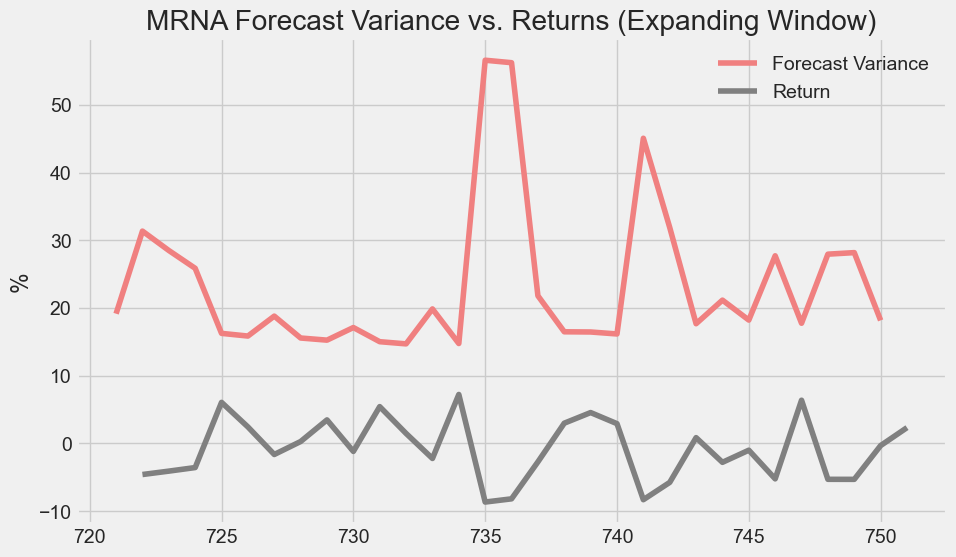

In [187]:
# Start location set to going back with a half year of trading days
start_loc = len(mrna) - round(0.5 * yearly_trade_days)

# Window of 60 days
end_loc = start_loc + 60

forecasts={}

for i in range(30):

    # Fit with fixed rolling window
    gjrgarch_expanding_rolling_result = gjrgarch_gm.fit(first_obs = start_loc, 
                                              last_obs = i + end_loc, 
                                              update_freq = 5,
                                              disp='off')
    
    # 1-period variance forecast and save the result
    temp_result_expanding = gjrgarch_expanding_rolling_result.forecast(horizon = 1).variance
    fcast = temp_result_expanding.loc[i + end_loc]
    forecasts[fcast.name] = fcast

# Create dataframe, transpose to get dates as rows and variance as column     
forecast_var_expanding = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.figure(figsize=(10,6))
plt.plot(forecast_var_expanding, color = 'lightcoral', label='Forecast Variance')
plt.plot(mrna.iloc[start_loc+60:end_loc+30]['return'], color = 'gray', label='Return')
plt.ylabel('%')
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns (Expanding Window)')
plt.show()

The expanding window doesn't seem to do as good a job in the beginning of the forecast period as with the fixed window.

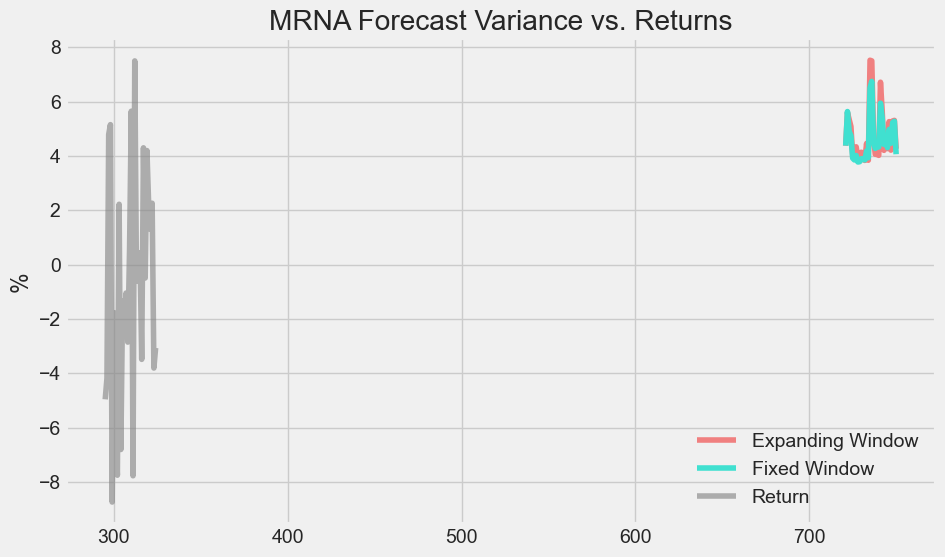

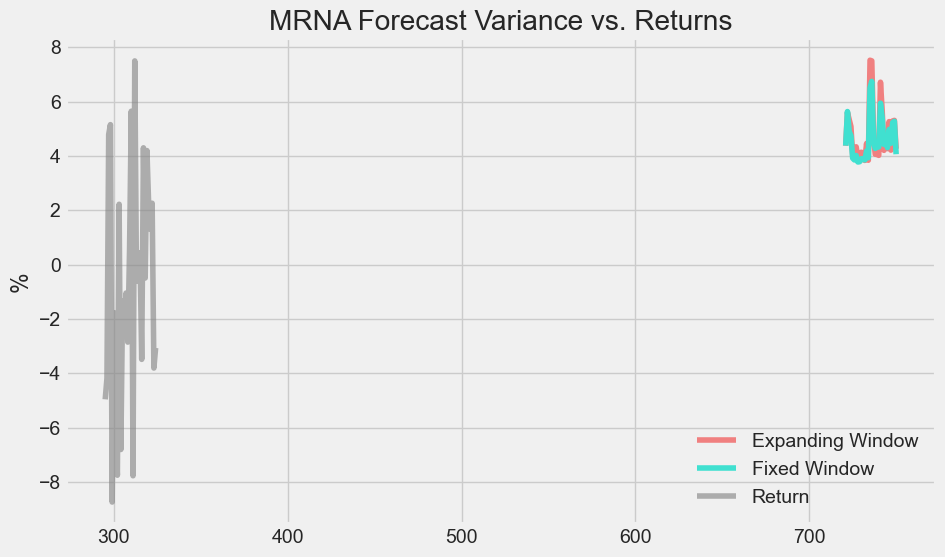

In [190]:
# Calculate volatility for fixed and expanding windows
fixed_window_volatility = np.sqrt(forecast_var_fixed)
expanding_window_volatility = np.sqrt(forecast_var_expanding)

# Plot volatility for fixed and expanding windows
plt.figure(figsize=(10,6))
plt.plot(expanding_window_volatility, color = 'lightcoral', label='Expanding Window')
plt.plot(fixed_window_volatility, color = 'turquoise', label='Fixed Window')
plt.plot(mrna[(mrna['Date']>='2020-10-09')&(mrna['Date']<='2020-11-19')]['return'], color = 'gray', alpha=0.6, label='Return')
plt.ylabel('%')
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns')
plt.show()

In [198]:
gjrgarch_result

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                            return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -2343.03
Distribution:      Standardized Skew Student's t   AIC:                           4700.07
Method:                       Maximum Likelihood   BIC:                           4732.74
                                                   No. Observations:                  787
Date:                           Tue, Apr 01 2025   Df Residuals:                      786
Time:                                   20:25:12   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

In [196]:
mrna[(mrna['Date']>='2020-10-09')&(mrna['Date']<='2020-11-19')]['return']

295   -4.958508
296   -4.182387
297    4.792440
298    5.152979
299   -8.739153
300   -1.767536
301   -6.115477
302   -7.751092
303    2.222222
304   -6.804734
305   -1.338854
306   -2.336318
307   -1.045695
308   -2.851766
309    0.536433
310    5.646954
311   -7.772166
312    7.499239
313   -0.608462
314    0.412870
315    0.439529
316   -3.486731
317    4.300132
318   -0.490815
319    4.199549
320    2.218015
321    1.296639
322    2.259666
323   -3.806361
324   -3.067322
Name: return, dtype: float64

The fixed window forecast shows more volatility (more conservative) than the expanding window forecast.  

## 9. Backtesting

In [192]:
# Variance from model
actual_var = gjrgarch_result.conditional_volatility ** 2 
actual_var


1      30.125157
2      24.702145
3      25.840270
4      24.980426
5      33.621381
         ...    
783    35.133983
784    28.671725
785    22.947870
786    20.823757
787    22.683934
Name: cond_vol, Length: 787, dtype: float64

In [197]:
forecast_var_fixed

array([[19.17039589],
       [31.74878512],
       [24.00844365],
       [22.53101628],
       [15.38462279],
       [14.85434068],
       [16.13896642],
       [14.27840498],
       [14.35142797],
       [15.20977789],
       [14.99789578],
       [14.8623878 ],
       [17.47443162],
       [15.49238039],
       [42.33029041],
       [45.50804692],
       [20.29086685],
       [18.30941594],
       [18.76834343],
       [18.76726904],
       [35.31360368],
       [29.11484388],
       [19.58656659],
       [21.690442  ],
       [18.54459057],
       [24.78225947],
       [19.9606922 ],
       [27.33650487],
       [27.84380187],
       [16.51617621]])

In [193]:
# actual_var = actual_var['2020-10-09':'2020-11-19']

# Convert actual and forecast variance to numpy arrays
actual_var, forecast_var_fixed = np.array(actual_var), np.array(forecast_var_fixed)

def evaluate(observation, forecast): 

    # MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
   
    # MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))

    # MAPE: not in scikitlearn, let's calculate it ourselves
    mape = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(mape))
    
    return mae, mse, mape

# Backtest model with MAE, MSE
evaluate(actual_var, forecast_var_fixed)

ValueError: Found input variables with inconsistent numbers of samples: [787, 30]

In [195]:
forecast_var_fixed

actual_var

array([ 30.12515742,  24.70214513,  25.84026956,  24.98042623,
        33.62138126,  49.91941565,  38.70757445,  38.80053064,
        29.63040075,  31.40509221,  34.13855187,  26.80935501,
        21.72117796,  35.67725776,  27.73307902,  38.68000781,
        29.6038891 ,  23.81052163,  20.59505948,  18.95004915,
        16.9750102 ,  15.33943813,  25.45114591,  23.24733707,
        30.6064057 ,  26.62573085,  21.6479113 ,  18.90581706,
        16.95245947,  19.14467814,  25.48019939,  25.15047242,
        20.63086415,  22.37294912,  79.82073402,  56.87265417,
        43.80287727,  78.3724449 ,  60.86476202,  58.64140073,
        80.86597181,  57.52423408,  43.23048072,  38.31379865,
        32.10406538,  26.89627543,  23.14347531,  19.33741452,
        17.13890636,  16.03946366,  15.15377526,  17.10199642,
        18.14177998,  17.27942115, 114.07285014, 197.89623949,
       134.20849539,  93.60601378,  67.04055155,  48.2947518 ,
        36.32688485,  28.4990953 ,  23.14922178,  24.94

MAPE of 39.4% is still quite high. In the future, we could try to improve model performance by adjusting forecast rolling window, model selection, and model parameters. 

## 10. Dynamic Value at Risk (VaR)

Since value at risk (VaR) is forward-looking, we'll generate a forecast and grab the forward-looking mean and volatility. There are 2 ways to calculate dynamic VaR: 

1. Parametric VaR: assumed distribution of standardized residuals
2. Empirical VaR: observed distribution of standardized residuals

In [ ]:
# Check our GJR-GARCH params - we'll use degrees of freedom (nu) and skew (lambda) for our VaR
gjrgarch_result.params

In [ ]:
# t distribution degrees of freedom (nu)
nu = gjrgarch_result.params[5]

# t distribution skew (lambda)
lam = gjrgarch_result.params[6]

# Forecast from 2020-01-01 onward 
gjrgarch_forecast = gjrgarch_result.forecast(start='2020-01-01')

# Forecast mean and variance 
mean_forecast = gjrgarch_forecast.mean['2020-01-01':]
variance_forecast = gjrgarch_forecast.variance['2020-01-01':]

# Parametric quantile, 2nd argument of .ppf must be in an array form
q_parametric = gjrgarch_gm.distribution.ppf(0.05, [nu, lam])
print('5% parametric quantile: ', q_parametric)

# Parametric VaR
VaR_parametric = mean_forecast.values + np.sqrt(variance_forecast).values * q_parametric
VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = variance_forecast.index)

# Empirical quantile
q_empirical = gjrgarch_std_resid.quantile(0.05)
print('5% empirical quantile: ', q_empirical)

# Emperical VaR
VaR_empirical = mean_forecast.values + np.sqrt(variance_forecast).values * q_empirical
VaR_empirical = pd.DataFrame(VaR_empirical, columns = ['5%'], index = variance_forecast.index)

# Plot
plt.figure(figsize=(12,7))
plt.plot(VaR_parametric, color = 'salmon', label = '5% Parametric VaR', alpha=0.7)
plt.plot(VaR_empirical, color = 'gold', label = '5% Empirical VaR', alpha=0.7)
colors = np.where(mrna['return']['2020-01-01':] < VaR_empirical['5%'],'slategray','turquoise') # where return<VaR, point is dark red
plt.scatter(variance_forecast.index, mrna['return']['2020-01-01':], color = colors, label = 'MRNA Returns')
plt.legend(loc = 'upper right', frameon=False)
plt.ylabel('%')
plt.title('MRNA VaR')


The parametric and empircal VaR are similar. The GJR-GARCH model looks like it's doing a pretty good job as fewer than 5% of the returns (in red) fall below the VaR threshold (VaR exceedence), which is our risk limit. More than 5% points falling below the threshold would mean our model is underestimating risk. The lower the VaR threshold line, the larger the model's loss estimates (more conservative).

Interestingly, as we'd expect with Moderna, VaR is lowest at the start of the the 1st major lockdown in the U.S. and when the company applied for FDA EUA for its covid vaccine, as well as key moments in vaccine development. 


In [ ]:
fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)

VaR_parametric = -VaR_parametric 
ax1.plot(mrna.loc[VaR_parametric.index[0]:].index, mrna.loc[VaR_parametric.index[0]:]['Adj Close'], color='turquoise', label='Adj Close')
ax2.plot(VaR_parametric['5%'].index, VaR_parametric['5%'], color='grey', label='5% VaR', alpha=0.4)

ax1.set(title='MRNA Price & VaR Threshold', xlabel='Date',ylabel='$ per Share')
ax2.set(ylabel='VaR (%)')
ax1.legend(loc='upper left', frameon=False)
ax2.legend(frameon=False)

ax1.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax1.text(pd.to_datetime('2020-08-17'), max(mrna['Adj Close']), 'Vaccine FDA EUA application', color='slategray')

Similarly to the above chart, the VaR threshold peaks at the start of the 1st major lockdown in the U.S. and at vaccine FDA EUA application. In the past year, the VaR threshold increased, as expected, during key events and with increasing return. 

## 11. References

https://learn.datacamp.com/courses/garch-models-in-python

https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/

https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/

https://pyflux.readthedocs.io/en/latest/garch.html

https://www.tandfonline.com/doi/abs/10.1080/13518470500039436

https://stats.stackexchange.com/questions/175400/optimal-lag-order-selection-for-a-garch-model

https://stats.stackexchange.com/questions/136267/maximum-likelihood-in-the-gjr-garch1-1-model?noredirect=1&lq=1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

https://www.amazon.de/Market-Risk-Analysis-Financial-Instruments/dp/B009NNW5A8

https://stats.stackexchange.com/questions/246113/what-to-do-with-an-insignificant-intercept-in-a-garch-model

https://stats.stackexchange.com/questions/202493/should-i-keep-a-non-significant-intercept-in-a-garch-model

https://vlab.stern.nyu.edu/docs/volatility/GJR-GARCH

